In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib as mpl
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [216]:
# Intersection between two lists
def intersection(lst1, lst2):
    lst3 = [int(value) for value in lst1 if value in lst2]
    return lst3

def set_null_partition_to_reference(key,set_references):
    for k,v in set_references.items():
        if v == key:
            set_references[k] = -1
    
    
# Remove partitions which are not present in both sets
def get_new_partitions_dict_2(intermediaries_occ_dict, officer_occ_dict,intermediaries_partition, officers_partition,intermediaries_references,officers_references):
    keys_intermediaries_dict = list(intermediaries_occ_dict.keys())
    keys_officers_dict = list(officer_occ_dict.keys())
    both_partition = intersection(keys_intermediaries_dict,keys_officers_dict)
    new_intermediaries_occurrences_dict = {}
    new_officer_occurrences_dict = {}
    for k in both_partition:
        new_intermediaries_occurrences_dict[k] = intermediaries_occ_dict[k]
        new_officer_occurrences_dict[k] =  officer_occ_dict[k]
    
    for k in intermediaries_occ_dict:
        if not k in new_intermediaries_occurrences_dict:
            intermediaries_partition[:] = [x if x != k else -1 for x in intermediaries_partition]
            set_null_partition_to_reference(k,intermediaries_references)
    for k in officer_occ_dict:
        if not k in new_officer_occurrences_dict:
            officers_partition[:] = [x if x != k else -1 for x in officers_partition]
            set_null_partition_to_reference(k,officers_references)



# Remove partitions which are not present in both sets
def get_new_partitions_dict(intermediaries_occ_dict, officer_occ_dict,intermediaries_partition, officers_partition):
    keys_intermediaries_dict = list(intermediaries_occ_dict.keys())
    keys_officers_dict = list(officer_occ_dict.keys())
    both_partition = intersection(keys_intermediaries_dict,keys_officers_dict)
    new_intermediaries_occurrences_dict = {}
    new_officer_occurrences_dict = {}
    for k in both_partition:
        new_intermediaries_occurrences_dict[k] = intermediaries_occ_dict[k]
        new_officer_occurrences_dict[k] =  officer_occ_dict[k]
    
    for k in intermediaries_occ_dict:
        if not k in new_intermediaries_occurrences_dict:
            intermediaries_partition[:] = [x if x != k else -1 for x in intermediaries_partition]
    for k in officer_occ_dict:
        if not k in new_officer_occurrences_dict:
            officers_partition[:] = [x if x != k else -1 for x in officers_partition]
            
# Convert dataframe column values to dict avoiding NaN 
def partition_to_dict(parse_list):
    partition_dict = {}
    counter = 0
    for partition in parse_list:
        if not np.isnan(partition):
            partition_dict[counter] = partition
            counter = counter+1
        else: 
            break
    return partition_dict

# Sort dictionary map by values
def sort_by_partition(parse_dict):
    partition_sorted = {k: v for k, v in sorted(parse_dict.items(), key=lambda item: item[1])}
    return partition_sorted,list(partition_sorted.values())

# Order partitions of each set by dimensions
def sort_partitions_by_dimensions(intermedaries_partition,officers_partition):
    dimension_intermediaries = dict(Counter(intermedaries_partition))
    dimension_officers = dict(Counter(officers_partition))

    # Revisamos el tamaño de la comunidad
    dimension_partition = {}
    for k,v in dimension_intermediaries.items():
        dimension_partition[k] = v * dimension_officers[k]
    dimension_partition_sorted = {k: v for k, v in sorted(dimension_partition.items(), key=lambda item: item[1],reverse=True)}

    # Ordenamos grupos
    sorted_array_partitions_intermediaries = []
    sorted_array_partitions_officers = []
    for k,v in dimension_partition_sorted.items():
        sorted_array_partitions_intermediaries.extend([k]*int(dimension_intermediaries[k]))
        sorted_array_partitions_officers.extend([k]*int(dimension_officers[k]))
    return sorted_array_partitions_intermediaries,sorted_array_partitions_officers




def remap_ids_references(set_references, sorted_array):
    new_set_reference = {}
    counter = 0
    for i, val in enumerate(sorted_array):
        if i == 0 or sorted_array[i] != sorted_array[i-1]:
            counter = 0
        else:
            counter = counter+1
        dict_counter_occurrence = 0
        for k,u in set_references.items():
            if u == val and counter == dict_counter_occurrence:
                new_set_reference[i] = k
                break
            elif u == val:
                dict_counter_occurrence = dict_counter_occurrence+1
    return new_set_reference

def compute_adjacency(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references):
    for i in range(len(partition_matrix)):
        for j in range(len(partition_matrix[i])):
                    partition_matrix[i][j] = original_matrix[new_intermediaries_references[i]][new_officers_references[j]]

def compute_adjacency_no_partition(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references):
    for i in range(len(partition_matrix)):
        for j in range(len(partition_matrix[i])):
            if partition_matrix[i][j] < 1:
                if original_matrix[new_intermediaries_references[i]][new_officers_references[j]] > 0:
                    partition_matrix[i][j] = 39
                    
# Biadjacency matrix creation. If row id and column id belong to same partition, we set value
def compute_adjacency_matrix(partition_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers):
    counter = 0
    last_value = None
    for i in range(len(partition_matrix)):
        for j in range(len(partition_matrix[i])):
            if (sorted_array_partitions_intermediaries[i] == sorted_array_partitions_officers[j]):
                if last_value != sorted_array_partitions_intermediaries[i]:
                    counter =counter+1
                    partition_matrix[i][j] = counter
                    last_value = sorted_array_partitions_intermediaries[i]
                else:
                    partition_matrix[i][j] = counter
# Function which returns where ends each partition
def count_splits(sorted_array_partitions):
    counter_set = []
    counter=-1
    for i, val in enumerate(sorted_array_partitions):
        if i !=0 and sorted_array_partitions[i] != sorted_array_partitions[i-1]:
            counter_set.append(i-1)
    return counter_set

# Remap id's after split partitions
def remap_references_partition(set_references,counter_set):
    new_dict_set_references = []
    new_item_references = {}
    counter = 0
    count_id = 0
    for k,v in set_references.items():
        new_item_references[count_id] = v
        if k == counter_set[counter]:
            new_dict_set_references.append(new_item_references)
            counter = counter +1
            new_item_references = {}
            count_id = 0
        else: 
            count_id = count_id +1 
        if counter == 9:
            break
    return new_dict_set_references

# Get the 9th greatest partitions adjacency matrix with weights
def compute_greatest_partition_matrix(original_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers,new_intermediaries_references,new_officers_references):
    """
    counter_intermediaries = []
    counter=-1
    for i, val in enumerate(sorted_array_partitions_intermediaries):
        if i !=0 and sorted_array_partitions_intermediaries[i] != sorted_array_partitions_intermediaries[i-1]:
            counter_intermediaries.append(i-1)
    counter_officers = []
    counter=-1
    for i, val in enumerate(sorted_array_partitions_officers):
        if i !=0 and sorted_array_partitions_officers[i] != sorted_array_partitions_officers[i-1]:
            counter_officers.append(i-1)
        else:
            counter=+1
            

    new_dict_intermediaries_references = []
    new_item_references = {}
    counter = 0
    count_id = 0
    for k,v in new_intermediaries_references.items():
        new_item_references[count_id] = v
        if k == counter_intermediaries[counter]:
            new_dict_intermediaries_references.append(new_item_references)
            counter = counter +1
            new_item_references = {}
            count_id = 0
        else: 
            count_id = count_id +1 
        if counter == 9:
            break
          
    new_item_references = {}
    new_dict_officers_references = []
    counter = 0
    count_id = 0
    for k,v in new_officers_references.items():
        new_item_references[count_id] = v
        if k == counter_officers[counter]:
            new_dict_officers_references.append(new_item_references)
            counter = counter +1
            new_item_references = {}
            count_id = 0
        else: 
            count_id = count_id +1 
        if counter == 9:
            break
    """       
    new_dict_intermediaries_references = remap_references_partition(new_intermediaries_references,count_splits(sorted_array_partitions_intermediaries))
    new_dict_officers_references = remap_references_partition(new_officers_references,count_splits(sorted_array_partitions_officers))    
    array_of_matrix = []
    for i in range(9):
        counter = 0
        print(len(list(new_dict_intermediaries_references[i].keys())))
        print(len(list(new_dict_officers_references[i].keys())))
        matrix_partition = np.zeros((len(list(new_dict_intermediaries_references[i].keys())),len(list(new_dict_officers_references[i].keys()))), dtype=int)
        for j in range(len(matrix_partition)):
            for k in range(len(matrix_partition[i])):
                if  original_matrix[new_dict_intermediaries_references[i][j]][new_dict_officers_references[i][k]] > 0:
                    counter = counter +1
                matrix_partition[j][k] = original_matrix[new_dict_intermediaries_references[i][j]][new_dict_officers_references[i][k]]
        array_of_matrix.append(matrix_partition)

    return array_of_matrix                    
                    
# Get greatest partition adjacency matrix with weights
def compute_first_partition_matrix(original_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers,new_intermediaries_references,new_officers_references):
    counter_intermediaries = 0
    for i in sorted_array_partitions_intermediaries:
        if i != 0:
            break
        else:
            counter_intermediaries = counter_intermediaries +1
    counter_officers = 0
    for i in sorted_array_partitions_officers:
        if i != 0:
            break
        else:
            counter_officers = counter_officers +1
    new_intermediaries_references = {k: new_intermediaries_references[k] for k in list(new_intermediaries_references)[:counter_intermediaries]}
    new_officers_references = {k: new_officers_references[k] for k in list(new_officers_references)[:counter_officers]}
    matrix_first_partition = np.zeros((len(list(new_intermediaries_references.keys())),len(list(new_officers_references.keys()))), dtype=int)
    counter = 0
    for i in range(len(matrix_first_partition)):
        for j in range(len(matrix_first_partition[i])):
            if  original_matrix[new_intermediaries_references[i]][new_officers_references[j]] > 0:
                counter = counter +1
            matrix_first_partition[i][j] = original_matrix[new_intermediaries_references[i]][new_officers_references[j]]
    print("Counter densitat", counter)
    return matrix_first_partition
    
# Main function which computes modularity adjacency matrix
def compute_partition_modularity(df,original_matrix):
    intermediaries_references,intermediaries_partition = sort_by_partition(partition_to_dict(df['rows'].tolist()))
    intermediaries_partition = [int(a) for a in intermediaries_partition] ## List to integers
    officers_references,officers_partition = sort_by_partition(partition_to_dict(df['cols'].tolist()))
    officers_partition = [int(a) for a in officers_partition] ## List to integers
    partition_matrix = np.zeros((len(intermediaries_partition),len(officers_partition)), dtype=int)
    sorted_array_partitions_intermediaries,sorted_array_partitions_officers = sort_partitions_by_dimensions(intermediaries_partition,officers_partition)
    new_intermediaries_references = remap_ids_references(intermediaries_references,sorted_array_partitions_intermediaries) # Get remap of id's
    new_officers_references = remap_ids_references(officers_references,sorted_array_partitions_officers) # Get remap of id's
    #compute_adjacency_matrix(partition_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers)
    #compute_adjacency_no_partition(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references)
    compute_adjacency(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references)
    #matrix_first_partition = compute_first_partition_matrix(original_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers,new_intermediaries_references,new_officers_references) # Get first partition adjacency matrix
    array_of_matrix = compute_greatest_partition_matrix(original_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers,new_intermediaries_references,new_officers_references) # Get 9th greatest partition adjacency matrix 
    return partition_matrix,array_of_matrix


# Main function which computes ibn adjacency matrix
def compute_partition_ibn(df,original_matrix):
    intermediaries_references,intermediaries_partition = sort_by_partition(partition_to_dict(df['rows'].tolist()))
    intermediaries_partition = [int(a) for a in intermediaries_partition] ## List to integers
    officers_references,officers_partition = sort_by_partition(partition_to_dict(df['cols'].tolist()))
    officers_partition = [int(a) for a in officers_partition] ## List to integers
    intermediaries_occurrences = dict(Counter(intermediaries_partition)) ## Occurrences of each partition
    officers_occurrences = dict(Counter(officers_partition)) ## Occurrences of each partition
    #get_new_partitions_dict(intermediaries_occurrences,officers_occurrences,intermediaries_partition,officers_partition)
    get_new_partitions_dict_2(intermediaries_occurrences,officers_occurrences,intermediaries_partition,officers_partition,intermediaries_references,officers_references)
    partition_matrix = np.zeros((len(intermediaries_partition),len(officers_partition)), dtype=int)
    sorted_array_partitions_intermediaries,sorted_array_partitions_officers = sort_partitions_by_dimensions(intermediaries_partition,officers_partition)
    new_intermediaries_references = remap_ids_references(intermediaries_references,sorted_array_partitions_intermediaries) # Get remap of id's
    new_officers_references = remap_ids_references(officers_references,sorted_array_partitions_officers) # Get remap of id's
    #compute_adjacency_matrix(partition_matrix,sorted_array_partitions_intermediaries,sorted_array_partitions_officers)
    #compute_adjacency_no_partition(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references)
    compute_adjacency(partition_matrix,original_matrix,new_intermediaries_references,new_officers_references)
    return partition_matrix



In [217]:
original_matrix = np.loadtxt(open("matrix-bipartite.csv", "rb"), delimiter=",",dtype='int')

In [218]:
##Modularity
df = pd.read_csv('modularity_partitions_csvfile.csv')
partition_matrix_mod,matrix_first_partition = compute_partition_modularity(df,original_matrix)

194
286
103
196
111
179
109
177
105
177
106
175
96
178
83
190
88
126


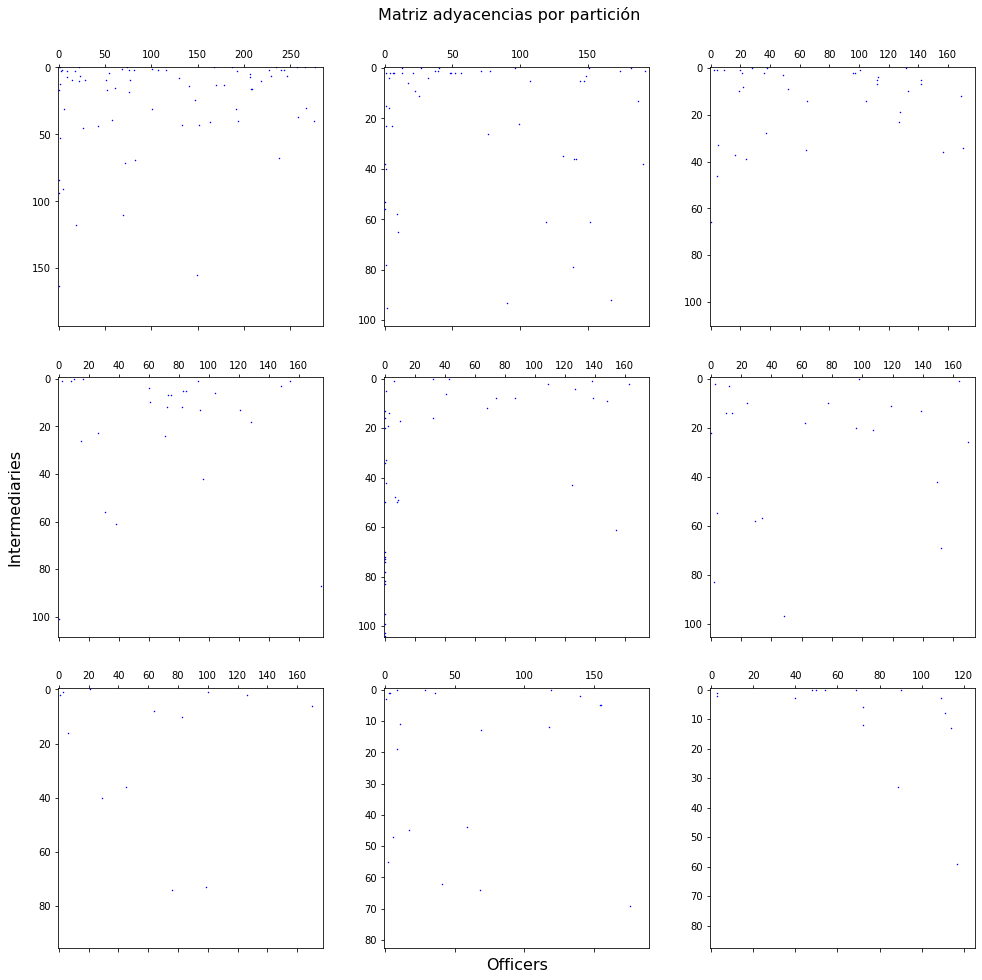

In [219]:
## Components degree histogram same plot (subplots)
fig, axs = plt.subplots(3,3,figsize=(14,14))
fig.suptitle('Matriz adyacencias por partición',fontsize=16)
fig.tight_layout(pad=3.0)
row = 0
column = 0
for i,k in enumerate(matrix_first_partition):
    axs[row,column].spy(k,aspect="auto", markersize=0.5,alpha =1,color='blue')
    if column > 1:
        column = 0
        row = row+1
    else:
        column=column+1
axs[1,0].set_ylabel('Intermediaries',fontsize=16,labelpad=10)
axs[2,1].set_xlabel('Officers',fontsize=16,labelpad=10)
#plt.ylabel("Ocurrencias",fontsize=16)
plt.show()

In [220]:
# Colormap creation
cmap = plt.cm.jet  # Choose the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be white
cmaplist[0] = (1, 1, 1, 1.0)

# New cmap
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 38, 39)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

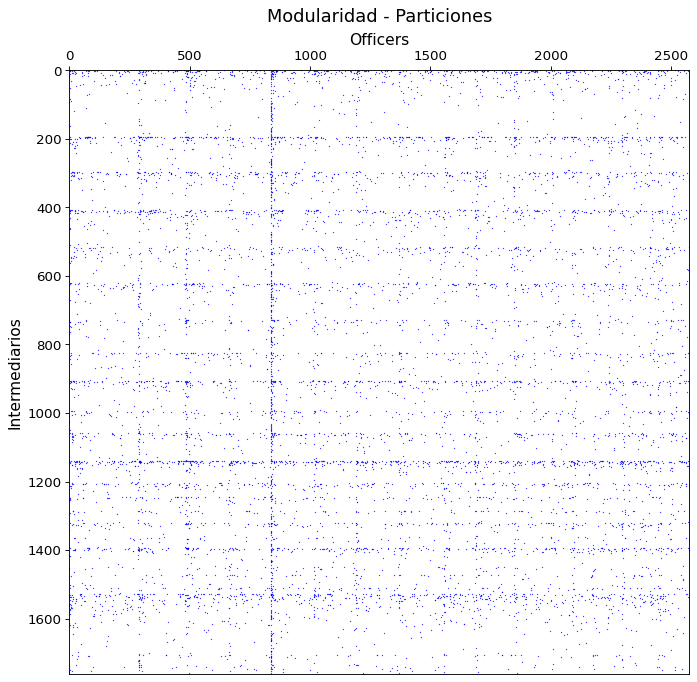

In [221]:
## Modularity plot
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.spy(partition_matrix_mod,aspect="auto", markersize=0.2,alpha =1,color='blue')
axs.set_title("Modularidad - Particiones",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
#plt.xlim(70000,80000)
#plt.ylim(0,50)
axs.xaxis.set_label_position('top')
axs.xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [222]:
## In-block nestedness
df = pd.read_csv('in-block_partitions_csvfile.csv')
partition_matrix_ibn = compute_partition_ibn(df,original_matrix)

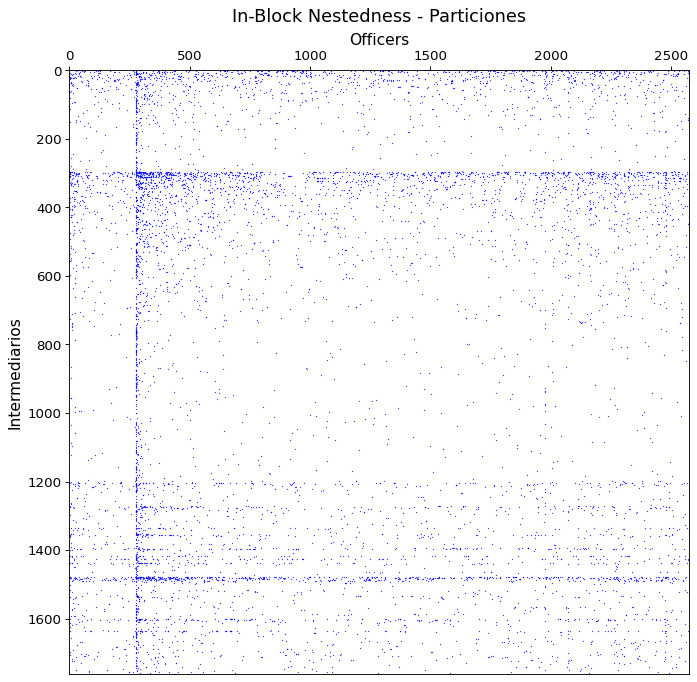

In [223]:
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.spy(partition_matrix_ibn,aspect="auto", markersize=0.2,alpha =1,color='blue')
axs.set_title("In-Block Nestedness - Particiones",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
axs.xaxis.set_label_position('top')
#plt.xlim(70000,80000)
#plt.ylim(0,50)
axs.xaxis.set_label_position('top')
axs.xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

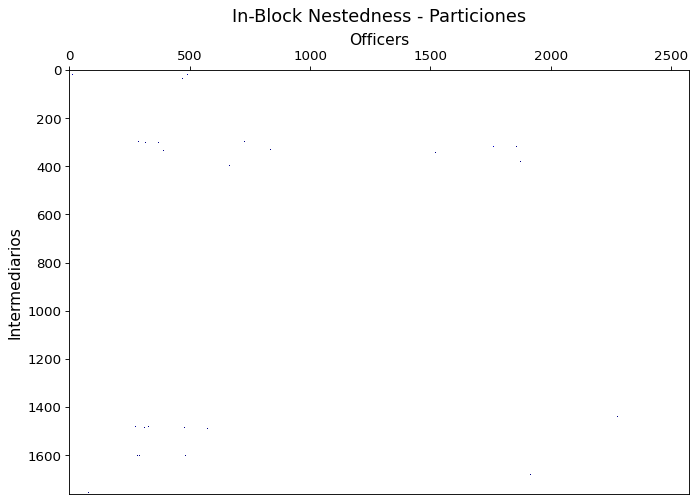

In [224]:
# IBN plot
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.imshow(partition_matrix_ibn, cmap=cmap, interpolation='nearest')
axs.set_title("In-Block Nestedness - Particiones",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
axs.xaxis.set_label_position('top')
axs.xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

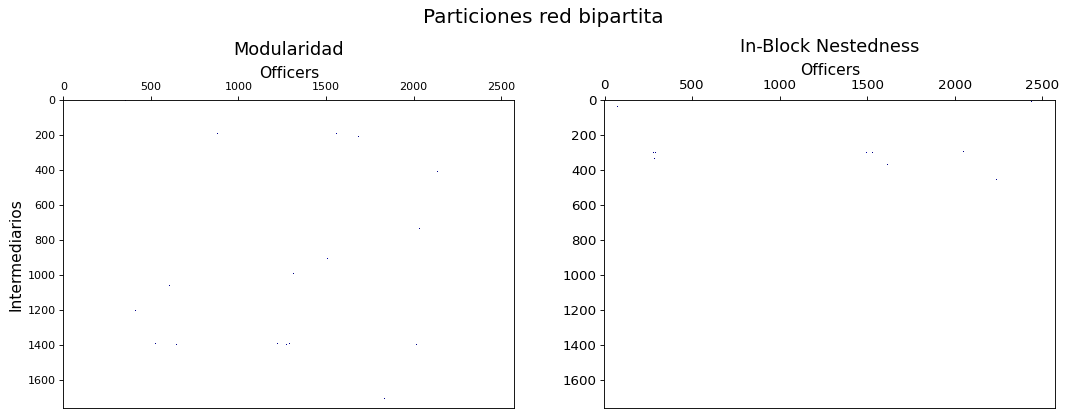

In [225]:
fig, axs = plt.subplots(1,2,figsize=(16, 16),dpi=80)
fig.suptitle('Particiones red bipartita',fontsize=18)
fig.subplots_adjust(top=1.45)
axs[0].imshow(partition_matrix_mod, cmap=cmap, interpolation='nearest')
axs[0].set_title("Modularidad",pad=10,fontsize=16)
axs[0].set_ylabel("Intermediarios",fontsize=14)
axs[0].set_xlabel("Officers",fontsize=14)
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_ticks_position('top')
axs[1].imshow(partition_matrix_ibn, cmap=cmap, interpolation='nearest')
axs[1].set_title("In-Block Nestedness",pad=10,fontsize=16)
#axs[1].set_ylabel("Intermediarios",fontsize=14)
axs[1].set_xlabel("Officers",fontsize=14)
axs[1].xaxis.set_label_position('top')
axs[1].xaxis.set_ticks_position('top')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()